In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [3]:
! pip install kaggle 

In [7]:
!mkdir .kaggle



mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
!ls

sample_data


In [0]:
import json
token = {"username":"jayfaldu20","key":"34727d8ffa800e12266a0b0a02b3d1ef"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [14]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          56221  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          35904  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           8419  
noriuk/us-education-datasets-unification-project             U.S. Education Datasets: Unification Project         85MB  2019-03-02 18:41:52           6049  
vjchoudhary7/customer-segmentation-tutorial-in-python     

In [16]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [17]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 97% 582M/600M [00:03<00:00, 146MB/s]
100% 600M/600M [00:03<00:00, 180MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 57.7MB/s]


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [19]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms=get_transforms(flip_vert=True,max_warp=0.,max_lighting=0.1,max_zoom=1.05)

In [0]:
np.random.seed(42)
src=(ImageList.from_csv(path,'train_v2.csv',folder='train-jpg',suffix='.jpg')
      .split_by_rand_pct(0.2)
      .label_from_df(label_delim=' '))

In [0]:
data=src.transform(tfms,size=128).databunch().normalize(imagenet_stats)

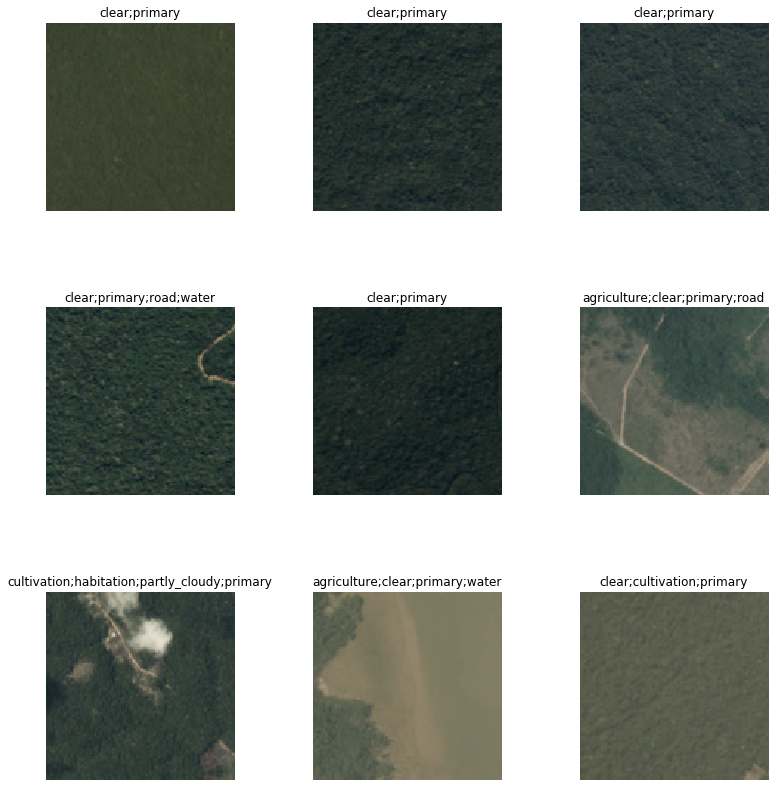

In [23]:
data.show_batch(rows=3,figsize=(11,12))

In [0]:
arch=models.resnet50

In [25]:
acc_02=partial(accuracy_thresh,thresh=0.2)
f_score=partial(fbeta,thresh=0.2)
learn=cnn_learner(data,arch,metrics=[acc_02,f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 144282504.73it/s]


In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


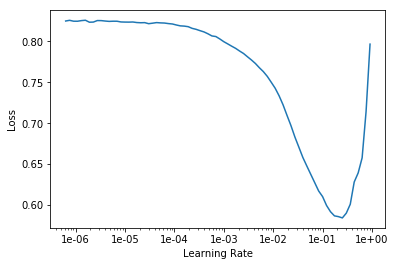

In [27]:
learn.recorder.plot()

In [0]:
lr=0.01

In [29]:
learn.fit_one_cycle(4,max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.122311,0.108669,0.944941,0.906814,02:35
1,0.108751,0.098609,0.953552,0.915049,02:36
2,0.101202,0.089344,0.952527,0.921440,02:32
3,0.093041,0.087972,0.956705,0.925002,02:35


In [0]:
learn.save('stage-1-128')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


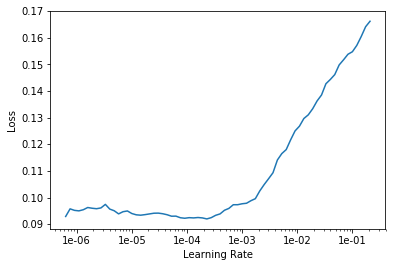

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(3,max_lr=slice(9e-6,3e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094711,0.087986,0.956582,0.925315,02:44
1,0.088071,0.085732,0.956938,0.926008,02:42
2,0.086364,0.084905,0.958958,0.927372,02:45


In [0]:
data=src.transform(tfms,size=256).databunch().normalize(imagenet_stats)

In [0]:
learn.data=data

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


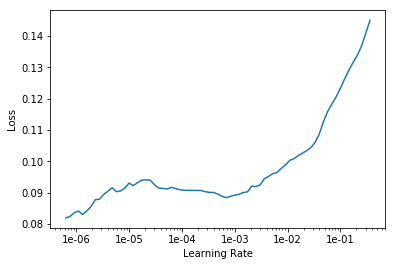

In [48]:
learn.recorder.plot()

In [0]:
learn.freeze()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(4,max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


In [40]:
learn.fit_one_cycle(2,max_lr=slice(3e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.108386,0.100613,0.957629,0.913410,06:33
1,0.104766,0.129057,0.957861,0.916372,06:31


In [0]:
learn.unfreeze()

In [44]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124519,0.755730,0.952484,0.908093,08:48
1,0.117919,2.135357,0.941074,0.883588,08:47
2,0.107447,0.894234,0.953843,0.909000,08:47
3,0.104590,0.639996,0.950158,0.906794,08:47
4,0.107439,0.322437,0.951234,0.909848,08:47


In [0]:
lr=1e-2/2